# COMP30850 Assignment 2
### by Ravikanth Gollapalli 18361993

- The goal of this assignment is to construct and characterise a range of network representations, created from pre-collected Twitter data for a specific Twitter List of user accounts which relate to a particular topic.
- For this assignment, I decided to go for Business as my topic of analysis.

In [1]:
#importing necessary libraries
import json
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from networkx.algorithms import bipartite
from collections import Counter
import itertools

## Task 1 - Follower Network
- Each node in this network represents a user from the user list I was given.

In [2]:
#create a network called followersNetwork
#since it is twitter, I use a directed graph
followersNetwork = nx.DiGraph()

In [3]:
#using the information from the friendships csv, I was able to derive that each pair of X,Y followers
#separated by a space, meant X follows Y on twitter
#created this network using the read_edgelist function in networkx
followerGraph = nx.read_edgelist( "business/friendships.csv" , delimiter = "\t", create_using=followersNetwork)

In [4]:
#created a function to make the network graphs 
def makeGraph(graph, col, title):
    plt.figure(figsize=(15,15))
    title = title 
    plt.title(title, fontsize=14)
    plt.margins(0.01, 0.01)
    pos = nx.spring_layout(graph)
    nx.draw_networkx(graph, pos, with_labels=True, font_size=8, node_size=200, node_color=col, edge_color="lightblue")
    plt.show() 

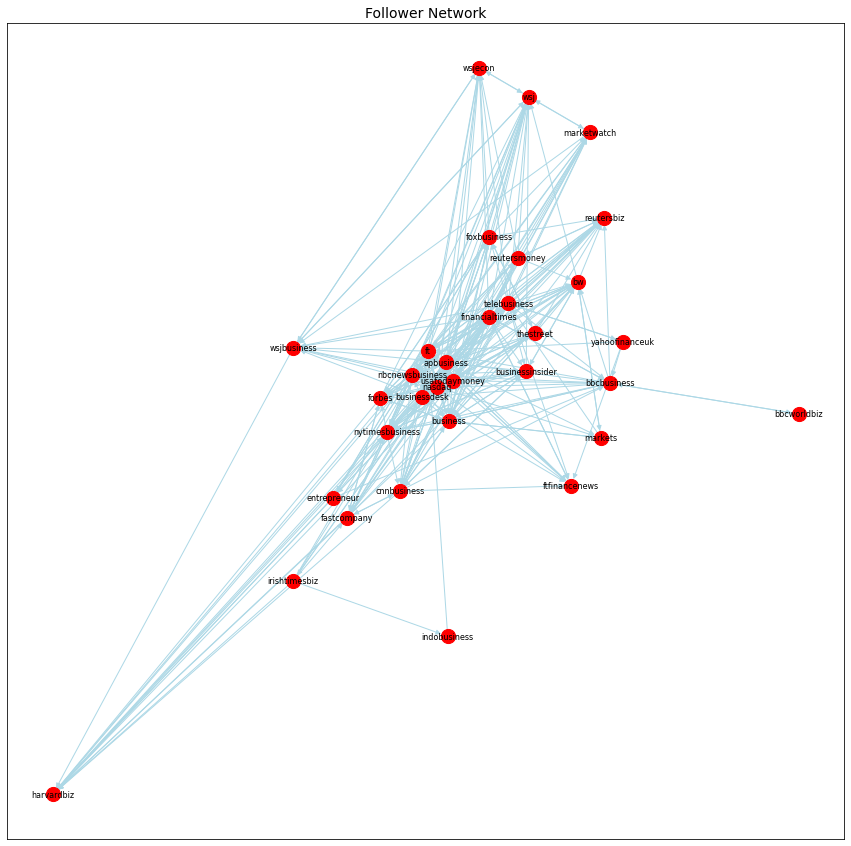

In [5]:
#drawing the follower network
makeGraph(followerGraph, "red", "Follower Network")

**Follower Network Characterisation**

In [6]:
#creating an indegree graph
in_deg = pd.Series(dict( nx.in_degree_centrality(followerGraph) ), name="in-degree")
pd.DataFrame(in_deg).sort_values(by="in-degree", ascending=False).head(10)

,in-degree
wsj,0.612903
business,0.548387
ft,0.548387
forbes,0.483871
reutersbiz,0.483871
nytimesbusiness,0.483871
bw,0.483871
financialtimes,0.451613
harvardbiz,0.451613
cnnbusiness,0.419355


As we can see, WSJ has the highest indegree meaning it has the most people in the list following it. This is a good indication as to how popular the account is

In [7]:
between = pd.Series(dict( nx.betweenness_centrality(followerGraph) ), name="betweenness")
pd.DataFrame(between).sort_values(by="betweenness", ascending=False).head(10)

,betweenness
ft,0.119832
businessdesk,0.086759
financialtimes,0.085332
nasdaq,0.083922
bbcbusiness,0.065382
telebusiness,0.057402
business,0.055221
nbcnewsbusiness,0.039000
nytimesbusiness,0.031131
irishtimesbiz,0.026882


FT has the highest betweenness which is a good indication as to how much influence the account has. It is seen as the bridging node as it connects account together

In [8]:
graphsData = {'Nodes': [followerGraph.number_of_nodes()], 'Edges': [followerGraph.number_of_edges()], 
              'Density': [nx.density(followerGraph)],'Reciprocity': [nx.reciprocity(followerGraph)]}
graphsData = pd.DataFrame(graphsData, columns = ['Nodes', 'Edges', 'Density', 'Reciprocity'], 
                  index=['Follower Network'])
graphsData

,Nodes,Edges,Density,Reciprocity
Follower Network,32,300,0.302419,0.44


- **Nodes:** We have 32 nodes.
- **Edges:** There are 300 edges for these 32 nodes.
- **Density:** The density of the graph is 0.3, which is relatively dense for a network suggesting close relations.
- **Reciprocity:** Nearly half the network follow each other

In [9]:
follower_degree = dict( followerGraph.degree())

In [10]:
degree_seq_follower = pd.Series(follower_degree)

In [11]:
degree_range = (degree_seq_follower.min(), degree_seq_follower.max())

In [12]:
degree_mean = degree_seq_follower.mean()

In [13]:
degree_median = degree_seq_follower.median()

In [14]:
#representing the data in the form of a dataframe for ease of viewing
DegreeData = {'Degree Range': [degree_range], 'Degree Mean': [degree_mean], 
              'Degree Median': [degree_median]}
DegreeData = pd.DataFrame(DegreeData, columns = ['Degree Range', 'Degree Mean', 'Degree Median'], 
                  index=['Follower Network'])
DegreeData

,Degree Range,Degree Mean,Degree Median
Follower Network,"(2, 36)",18.75,18.0


In [15]:
degree_seq_follower.to_frame(name="Followers").sort_values(by="Followers", ascending=False).head(10)

,Followers
ft,36
nasdaq,36
financialtimes,33
usatodaymoney,32
business,31
nbcnewsbusiness,29
businessdesk,26
nytimesbusiness,26
apbusiness,26
telebusiness,23


As we can see, FT and Nasdaq follow the most amount of accounts

In [16]:
# check all unique pairs to look for reciprocity
for pair in itertools.combinations(followerGraph.nodes(), r=2):
    if followerGraph.has_edge( pair[0], pair[1] ) and followerGraph.has_edge( pair[1], pair[0] ):
        print( "%s <--> %s" % pair )

apbusiness <--> foxbusiness
apbusiness <--> nasdaq
apbusiness <--> nbcnewsbusiness
bbcbusiness <--> business
bbcbusiness <--> financialtimes
bbcbusiness <--> bbcworldbiz
business <--> businessinsider
business <--> bw
business <--> cnnbusiness
business <--> financialtimes
business <--> forbes
business <--> foxbusiness
business <--> ft
business <--> markets
business <--> nytimesbusiness
businessinsider <--> bw
businessinsider <--> cnnbusiness
businessinsider <--> nasdaq
businessinsider <--> nytimesbusiness
bw <--> financialtimes
bw <--> ft
bw <--> markets
cnnbusiness <--> fastcompany
cnnbusiness <--> nasdaq
cnnbusiness <--> usatodaymoney
fastcompany <--> financialtimes
fastcompany <--> forbes
fastcompany <--> ft
financialtimes <--> ft
financialtimes <--> ftfinancenews
financialtimes <--> nasdaq
financialtimes <--> nbcnewsbusiness
financialtimes <--> reutersbiz
financialtimes <--> usatodaymoney
financialtimes <--> businessdesk
forbes <--> foxbusiness
forbes <--> nasdaq
forbes <--> thestre

These are the accounts that follow each other

In [17]:
#creating an undirected follower graph where it shows the reciprocal accounts
undirectedFollower = followerGraph.to_undirected( reciprocal=True )

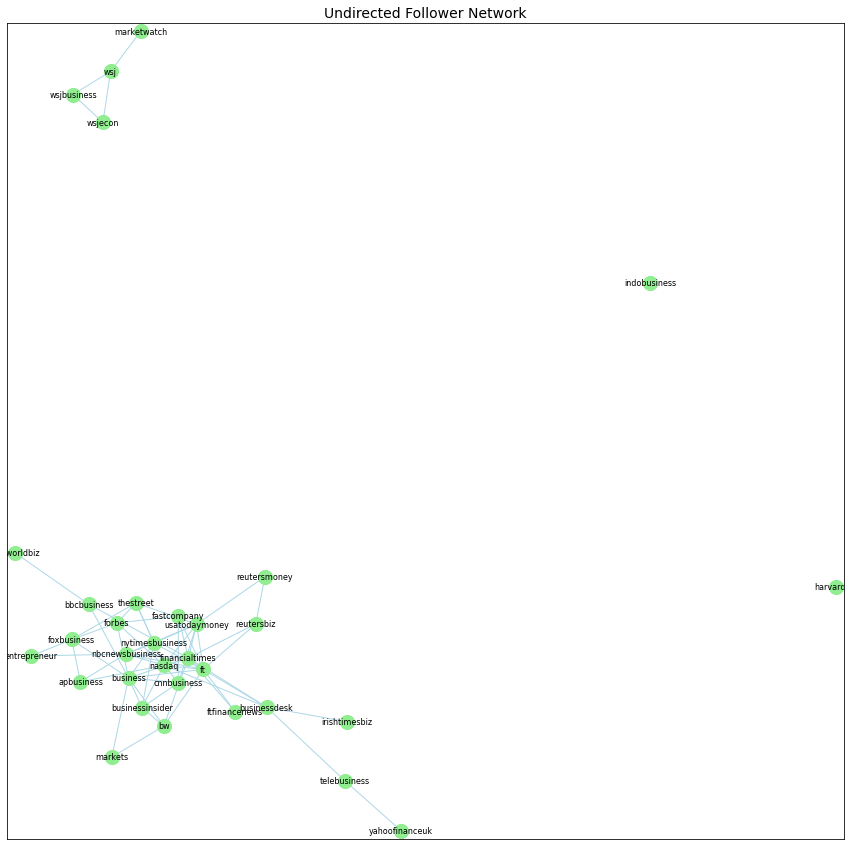

In [18]:
makeGraph(undirectedFollower, "lightgreen", "Undirected Follower Network")

In [19]:
graphsData = {'Nodes': [undirectedFollower.number_of_nodes()], 'Edges': [undirectedFollower.number_of_edges()], 
              'Density': [nx.density(undirectedFollower)], 
              'Number of Connected Components': [nx.number_connected_components(undirectedFollower)], 
              'Isolated Nodes': [list(nx.isolates(undirectedFollower))]}
graphsData = pd.DataFrame(graphsData, columns = ['Nodes', 'Edges', 'Density','Number of Connected Components','Isolated Nodes'], 
                  index=['Follower Network'])
graphsData

,Nodes,Edges,Density,Number of Connected Components,Isolated Nodes
Follower Network,32,66,0.133065,4,"[harvardbiz, indobusiness]"


As we can see from the graph and the table, the network is disjointed when it is undirected due to the fact that not all accounts follow each other. There are 4 connected components in total and 2 isolated nodes listed in the table. As a result, the graph is less dense and there are less edges

## Task 2 - Reply Network
- A node will represent any user on twitter that has received a reply from an account in the given list
- I will create a network to represent this and characterise it

In [20]:
#creating a directed network to represent replies
replyNetwork = nx.DiGraph()

In [21]:
#parsing the file
file = open( "business/tweets.jsonl", "r" )
tweets = []
# process the file line-by-line
for line in file.readlines():
    line = line.strip()
    # each line contains a JSON document, representing a single tweet
    tweet = json.loads(line)
    tweets.append(tweet)
file.close()
print("Read %d tweets" % len(tweets))

Read 16000 tweets


In [22]:
#creating a dataframe for this network
replyGraph = pd.DataFrame(tweets).set_index("id")

In [23]:
#list of useless columns
columns = ['id_str','created_at', 'truncated', 'display_text_range', 'favorited', 'retweeted','possibly_sensitive', 
           'lang', 'extended_entities', 'retweeted_status', 'quoted_status_id','quoted_status_id_str',
          'quoted_status_permalink', 'quoted_status', 'geo','coordinates','contributors','is_quote_status','retweet_count', 'favorite_count','place']

In [24]:
#dropping the useless columns
replyGraph = replyGraph.drop(columns, axis=1)

In [25]:
#normalising the users column in the dataframe
users = [] 
users=pd.json_normalize(replyGraph["user"])

In [26]:
#listing the only columns required
columnsNeeded = ['id','screen_name']

In [27]:
#dropping all other columns
users.drop(users.columns.difference(columnsNeeded), 1, inplace=True)

In [28]:
#joining the full table with the new users table
replyGraph = pd.concat([replyGraph.reset_index(drop=True),users.reset_index(drop=True)], axis=1)

In [29]:
#dropping all rows which have a null value in the the in reply to screen name column
replyGraph = replyGraph[replyGraph['in_reply_to_screen_name'].notna()]

In [30]:
#listing the only columns required
columnsNeeded = ['screen_name','in_reply_to_screen_name']

In [31]:
#dropping all other columns
replyGraph.drop(replyGraph.columns.difference(columnsNeeded), 1, inplace=True)
replyGraph.head(3)

,in_reply_to_screen_name,screen_name
47,telebusiness,telebusiness
170,benandjerrys,USATODAYmoney
244,Nasdaq,Nasdaq


In [32]:
#creating a function to see if there lies an edge between the two rows in the column
def checkEdge(network,col1, col2):
    if (network.has_edge(col1, col2)):
        return True
    else:
        return False

In [33]:
#adding all values in the in reply to screen name column as a node since this would add outside users too
for i,row in replyGraph.iterrows():
        replyNetwork.add_node(row["in_reply_to_screen_name"])

In [34]:
#creating an edge between the screen names of the accounts and the account they reply to
#the function checks if there is an edge between the screen name and the person being replied to, if so, weight is added
#if statement makes sure they are not replying to themselves
counter = 1
for i,rows in replyGraph.iterrows():
    if not (checkEdge(replyNetwork,rows["screen_name"], rows["in_reply_to_screen_name"])) and (rows['screen_name'] != rows['in_reply_to_screen_name']):
        replyNetwork.add_edge( rows["screen_name"], rows["in_reply_to_screen_name"], weight=counter) 
    elif (rows['screen_name'] != rows['in_reply_to_screen_name']):
        replyNetwork[rows["screen_name"]][rows["in_reply_to_screen_name"]]["weight"] = replyNetwork[rows["screen_name"]][rows["in_reply_to_screen_name"]]["weight"]+counter

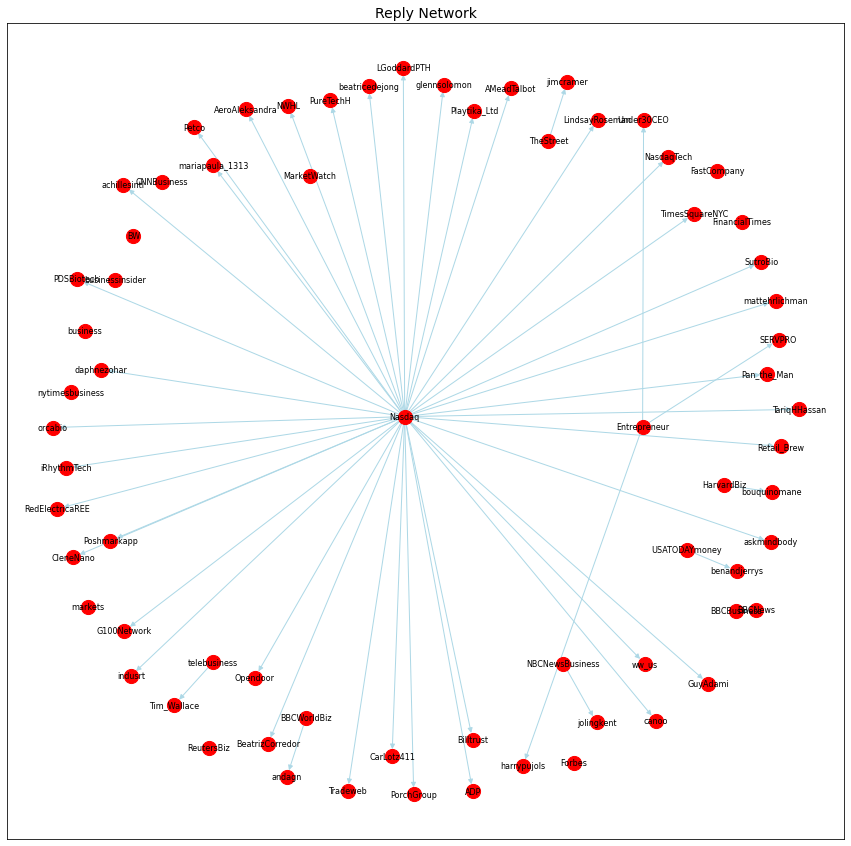

In [35]:
makeGraph(replyNetwork, "red", "Reply Network")

**Reply Network Characterisation**

In [36]:
graphsData = {'Nodes': [replyNetwork.number_of_nodes()], 'Edges': [replyNetwork.number_of_edges()], 
              'Density': [nx.density(replyNetwork)]}
graphsData = pd.DataFrame(graphsData, columns = ['Nodes', 'Edges', 'Density'], 
                  index=['Reply Network'])
graphsData

,Nodes,Edges,Density
Reply Network,69,49,0.010443


- **Nodes:** We have 69 nodes.
- **Edges:** There are 49 edges for these 69 nodes.
- **Density:** The density of the graph is 0.01, which suggests low density in the network.

In [37]:
reply_degree = dict( replyNetwork.degree())

In [38]:
degree_seq_reply = pd.Series(reply_degree)

In [39]:
degree_range = (degree_seq_reply.min(), degree_seq_reply.max())

In [40]:
degree_mean = degree_seq_reply.mean()

In [41]:
degree_median = degree_seq_reply.median()

In [42]:
#representing the data in the form of a dataframe for ease of viewing
DegreeData = {'Degree Range': [degree_range], 'Degree Mean': [degree_mean], 
              'Degree Median': [degree_median]}
DegreeData = pd.DataFrame(DegreeData, columns = ['Degree Range', 'Degree Mean', 'Degree Median'], 
                  index=['Reply Network'])
DegreeData

,Degree Range,Degree Mean,Degree Median
Reply Network,"(0, 39)",1.42029,1.0


In [43]:
#creating a function to draw a histogram, taking the name of the graph, colour, data, and column names are arguments
def drawHist(graph, col, data, x, y):
    hist = data.plot.hist(figsize=(8,6), fontsize=14, legend=None, color=col)
    hist.set_ylabel(x, fontsize=14)
    hist.set_xlabel(y, fontsize=14);

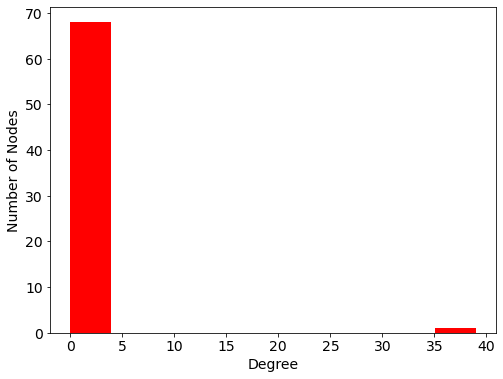

In [44]:
drawHist(replyNetwork, "red", degree_seq_reply, "Number of Nodes", "Degree")

As we can see from the table and the histogram, there is a low degree mean for the reply network. There is an outlier node with over 35 replies, but in general, it is quite low

In [45]:
degree_seq_reply.to_frame(name="replies").sort_values(by="replies", ascending=False).head(10)

,replies
Nasdaq,39
Entrepreneur,3
telebusiness,1
CarLotz411,1
Opendoor,1
Billtrust,1
NasdaqTech,1
GuyAdami,1
USATODAYmoney,1
achillesintl,1


As we can see, Nasdaq is the node that replies the most to other accounts. This suggests it has high engagement compared to the others. 

## Task 3 - Mention Network
- A Twitter mention network is a weighted directed network, where nodes are users, directed edges denote direction of mentions between users, and edge weights correspond to mention frequency.

In [46]:
#created a directed network
mentionNetwork = nx.DiGraph()

In [47]:
#creating a dataframe for this network
mentionGraph = pd.DataFrame(tweets).set_index("id")

In [48]:
#normalising the entities columnn
mentions = [] 
mentions = pd.json_normalize(mentionGraph["entities"])

In [49]:
mentions.head(2)

,hashtags,symbols,user_mentions,urls,media
0,[],[],[],"[{'url': 'https://t.co/HyEGHcXnep', 'expanded_...",NaN
1,[],[],[],"[{'url': 'https://t.co/k8MUYjKu8G', 'expanded_...",NaN


In [50]:
#column required
columnsNeeded = ['user_mentions']

In [51]:
#dropping all other columns
mentions.drop(mentions.columns.difference(columnsNeeded), 1, inplace=True)

In [52]:
#joining with the users table from the previous task
mentionGraph = pd.concat([users.reset_index(drop=True),mentions.reset_index(drop=True)], axis=1)

In [53]:
#if any entry in the user_mentions column has a length of greater than 0, we keep that row, else it is dropped 
mentionGraph = mentionGraph[mentionGraph['user_mentions'].map(lambda drop: len(drop)) > 0]
mentionGraph

,id,screen_name,user_mentions
14,2252205206,BBCWorldBiz,"[{'screen_name': 'robyounguk', 'name': 'Rob Yo..."
16,16737418,IrishTimesBiz,"[{'screen_name': 'IrishTimesBiz', 'name': 'Iri..."
24,224240358,ReutersMoney,"[{'screen_name': 'ReutersBiz', 'name': 'Reuter..."
25,2735591,FastCompany,"[{'screen_name': '88rising', 'name': '88rising..."
29,3066084185,APBusiness,"[{'screen_name': 'AP', 'name': 'The Associated..."
...,...,...,...
15974,69620713,markets,"[{'screen_name': 'wealth', 'name': 'Bloomberg ..."
15980,224240358,ReutersMoney,"[{'screen_name': 'ReutersBiz', 'name': 'Reuter..."
15987,28140646,WSJbusiness,"[{'screen_name': 'marcelolprince', 'name': 'Ma..."
15990,16737418,IrishTimesBiz,"[{'screen_name': 'IrishTimesBiz', 'name': 'Iri..."


In [54]:
#looping throught the table and the length of the column to add the node. 
#We add all the screen names that exist in the user_mentions column
for i, row in mentionGraph.iterrows():
    for j in range(len(row['user_mentions'])):
            mentionNetwork.add_node(row['user_mentions'][j]['screen_name'])

In [55]:
#looping throught the table and the length of the column to add the edge. 
#We connect all the screen names that exist in the user_mentions column with the screen names in the user column
#using the check edge function, we can see if there is an edge and add weights to the edges.
counter = 1
for i, row in mentionGraph.iterrows():
    for j in range(len(row['user_mentions'])):
            if not (checkEdge(mentionNetwork, row['screen_name'], row['user_mentions'][j]['screen_name'])):
                mentionNetwork.add_edge(row['screen_name'], row['user_mentions'][j]['screen_name'], weight = counter)
            elif (row['screen_name'] != row['user_mentions'][j]['screen_name']):
                mentionNetwork[row['screen_name']][row['user_mentions'][j]['screen_name']]["weight"] = mentionNetwork[row['screen_name']][row['user_mentions'][j]['screen_name']]["weight"]+counter


In [56]:
#seeing which accounts have the highest in degrees
in_deg = pd.Series(dict(mentionNetwork.in_degree(weight="weight")), name="w-in-degree")
pd.DataFrame(in_deg).sort_values(by="w-in-degree", ascending=False).head(10)

,w-in-degree
AP,249
ReutersBiz,185
Reuters,138
jimcramer,83
jolingkent,73
BloombergLive,69
TelegraphTech,57
freddiethekat,55
AP_Europe,54
LaurenYoung,49


Users with high weighted in-degree are most frequently mentioned by other users in their tweets

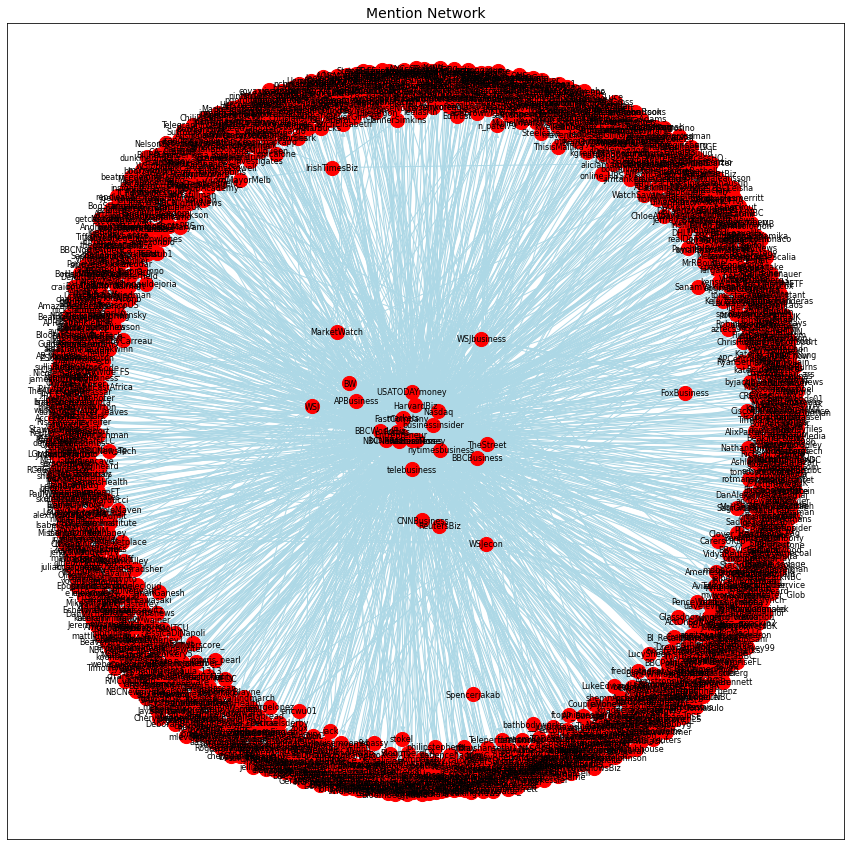

In [57]:
makeGraph(mentionNetwork, "red", "Mention Network")

**Mention Network Characterisation**

In [58]:
graphsData = {'Nodes': [mentionNetwork.number_of_nodes()], 'Edges': [mentionNetwork.number_of_edges()], 
              'Density': [nx.density(mentionNetwork)]}
graphsData = pd.DataFrame(graphsData, columns = ['Nodes', 'Edges', 'Density'], 
                  index=['Mention Network'])
graphsData

,Nodes,Edges,Density
Mention Network,1485,1582,0.000718


In [59]:
ego_node = "WSJ"
ego = nx.ego_graph(mentionNetwork, ego_node)

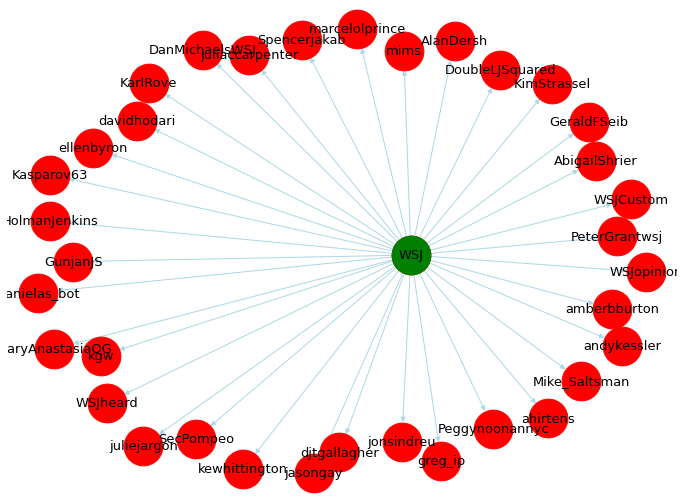

In [60]:
plt.figure(figsize=(12, 9))
plt.margins(0.001, 0.001)
pos = nx.spring_layout(ego)
nx.draw(ego, pos, with_labels = True, node_size=1500, font_size=13, node_color="red", edge_color="lightblue")
# add the ego node in a different colour
nx.draw_networkx_nodes(ego, pos, nodelist=[ego_node], node_size=1500, node_color="green");

Created an ego network with "WSJ" as the Ego node. The ego node replies to the following accounts

In [61]:
graphsData = {'Nodes': [ego.number_of_nodes()], 'Edges': [ego.number_of_edges()], 
              'Density': [nx.density(ego)]}
graphsData = pd.DataFrame(graphsData, columns = ['Nodes', 'Edges', 'Density'], 
                  index=['Mention Network'])
graphsData

,Nodes,Edges,Density
Mention Network,36,35,0.027778


As we can see, the ego network has a higher density than the full mentions network. This could make sense considering the ego one node is directed to all the nodes in the network

In [62]:
mention_degree = dict( mentionNetwork.degree())
ego_degree = dict( ego.degree())

In [63]:
degree_seq_mention = pd.Series(mention_degree)
degree_seq_ego = pd.Series(ego_degree)

In [64]:
degree_range = (degree_seq_mention.min(), degree_seq_mention.max())
degree_range_ego = (degree_seq_ego.min(), degree_seq_ego.max())

In [65]:
degree_mean = degree_seq_mention.mean()
degree_mean_ego = degree_seq_ego.mean()

In [66]:
degree_median = degree_seq_mention.median()
degree_median_ego = degree_seq_ego.median()

In [67]:
#representing the data in the form of a dataframe for ease of viewing
DegreeData = {'Degree Range': [degree_range, degree_range_ego], 'Degree Mean': [degree_mean, degree_mean_ego], 
              'Degree Median': [degree_median, degree_median_ego]}
DegreeData = pd.DataFrame(DegreeData, columns = ['Degree Range', 'Degree Mean', 'Degree Median'], 
                  index=['Mention Network', 'Ego Network'])
DegreeData

,Degree Range,Degree Mean,Degree Median
Mention Network,"(1, 200)",2.130640,1.0
Ego Network,"(1, 35)",1.944444,1.0


We can see the following statistics for the 2 networks. We can see that the degree mean is less for the ego network which makes sense given the less amount of nodes

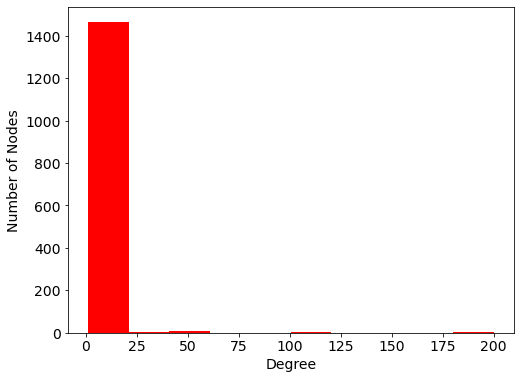

In [68]:
drawHist(mentionNetwork, "red", degree_seq_mention, "Number of Nodes", "Degree")

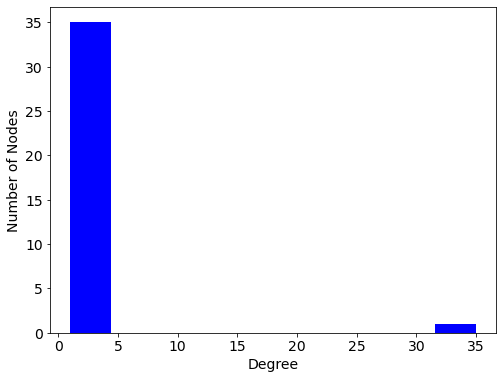

In [69]:
drawHist(ego, "blue", degree_seq_ego, "Number of Nodes", "Degree")

The Histogram illustrates the degree analysis that was done above

## Task 4 - User Hashtag Network
- A bipartite network, where one set of nodes will be users from the list, and the other set of nodes will be hashtags which appear in their tweets

In [70]:
#creating a dataframe with the tweets
userGraph = pd.DataFrame(tweets).set_index("id")

In [71]:
#columns that I need from the DF
columns = ["user", "entities"]

In [72]:
#dropping everything but the columns specified
userGraph.drop(userGraph.columns.difference(columns), 1, inplace=True)

In [73]:
#normalising the entities column
userHash = pd.json_normalize(userGraph["entities"])

In [74]:
#normalising the user column
userHash1 = pd.json_normalize(userGraph["user"])

In [75]:
#columns that I need from the DF
columnsNeeded = ['hashtags']

In [76]:
#dropping everything but the columns specified
userHash.drop(userHash.columns.difference(columnsNeeded), 1, inplace=True)

In [77]:
#columns that I need from the DF
columnsNeeded = ['name']

In [78]:
#dropping everything but the columns specified
userHash1.drop(userHash1.columns.difference(columnsNeeded), 1, inplace=True)

In [79]:
#joining the 2 columns together
userHashtag = pd.concat([userHash1.reset_index(drop=True),userHash.reset_index(drop=True)], axis=1)

In [80]:
userHashtag.head(5)

,name,hashtags
0,The Wall Street Journal,[]
1,Harvard Business Review,[]
2,Finance News,[]
3,The Wall Street Journal,[]
4,NYT Business,[]


In [81]:
#if any entry in the user_mentions column has a length of greater than 0, we keep that row, else it is dropped 
userHashtag = userHashtag[userHashtag['hashtags'].map(lambda drop: len(drop)) > 0]
userHashtag.head(5)

,name,hashtags
55,Reuters Money,"[{'text': 'AppleEvent', 'indices': [53, 64]}]"
108,Independent Business,"[{'text': 'sponsored', 'indices': [55, 65]}]"
127,BBC Business,"[{'text': 'Millionby30', 'indices': [137, 149]}]"
135,BBC World Business,"[{'text': 'Automotive', 'indices': [35, 46]}]"
160,Forbes,"[{'text': 'DecadeofU30', 'indices': [138, 150]}]"


In [82]:
#creating the bipartite network
hashNetwork = nx.Graph()
userNodes, hashNodes = set(), set()
commit_counts = Counter()
for i, row in userHashtag.iterrows():
    for j in range(len(row['hashtags'])):
    # add the user node
        if not row["name"] in users:
            userNodes.add( row["name"] )
            hashNetwork.add_node( row["name"], bipartite=0 )
    # add the hashtag node
        if not row['hashtags'][j]['text'] in users:
            hashNodes.add( row['hashtags'][j]['text'] )
            hashNetwork.add_node( row['hashtags'][j]['text'], bipartite=1 )
    # update the counts
        pair = frozenset([row["name"], row['hashtags'][j]['text']])
        commit_counts[pair] += 1

In [83]:
for pair in commit_counts:
    hashNetwork.add_edge( *pair, weight=commit_counts[pair] )

In [84]:
bipartite.is_bipartite( hashNetwork )

True

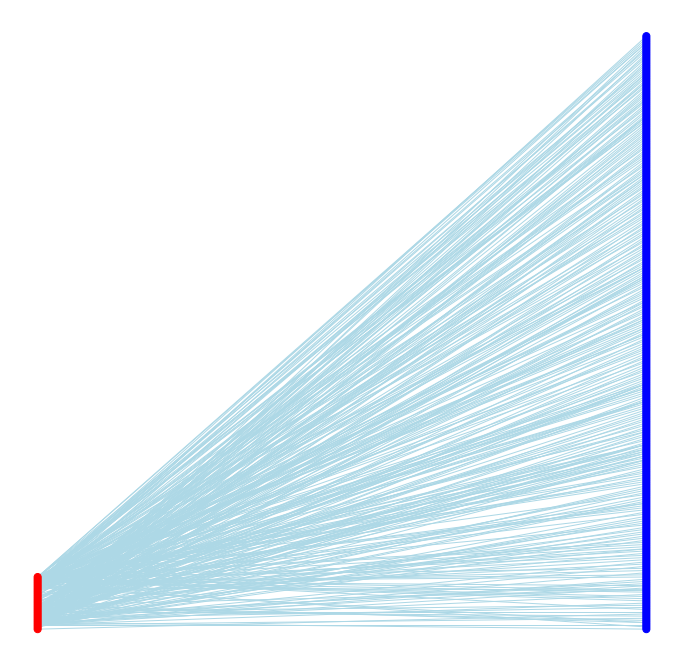

In [85]:
#drawing the network
# manually set the node colours and positions
color_map, pos = {}, {}
for i, node in enumerate(userNodes):
    pos[node] = (0, i*10)
    color_map[node] = "red"
for i, node in enumerate(hashNodes):
    pos[node] = (1, i*10)
    color_map[node] = "blue"
colors = [color_map[node] for node in hashNetwork.nodes()]
# draw the network    
plt.figure(figsize=(12,12))
nx.draw_networkx(hashNetwork, pos=pos, with_labels=False, 
        node_size = 50,
        font_size = 9,
        node_color = colors, edge_color = "lightblue")
plt.axis("off")
plt.show()

**Hashtag Network Characterisation**

In [86]:
graphsData = {'Nodes': [hashNetwork.number_of_nodes()], 'Edges': [hashNetwork.number_of_edges()], 
              'Density': [nx.density(hashNetwork)], 'is Bipartite?': [bipartite.is_bipartite(hashNetwork)], 
             'Users':[len(userNodes)], 'Hashtags': [len(hashNodes)]}
graphsData = pd.DataFrame(graphsData, columns = ['Nodes', 'Edges', 'Density', 'is Bipartite?', 'Users', 'Hashtags'], 
                  index=['Hashtag Network'])
graphsData

,Nodes,Edges,Density,is Bipartite?,Users,Hashtags
Hashtag Network,299,315,0.007071,True,25,274


Proving this network is bipartite. It also has a low density as we can see.

In [87]:
#listing neighbours
list(hashNetwork.neighbors("Bitcoin"))

['Reuters Business',
 'Bloomberg Markets',
 'Reuters Money',
 'Bloomberg',
 'TheStreet']

Picking a hashtag and seeing which accounts it is connected to. This makes sense as "Bitcoin" is associated with the finance based accounts

In [88]:
#listing neighbours
list(hashNetwork.neighbors("Reuters Business"))

['Bitcoin', 'wef', 'ReutersLive', 'bitcoin', 'Huawei', 'WEF21']

Seeing which hashtags are associated with a given account

In [89]:
hash_degree = dict( hashNetwork.degree())

In [90]:
degree_seq_hash = pd.Series(hash_degree)

In [91]:
degree_range = (degree_seq_hash.min(), degree_seq_hash.max())

In [92]:
degree_mean = degree_seq_hash.mean()

In [93]:
degree_median = degree_seq_hash.median()

In [94]:
#representing the data in the form of a dataframe for ease of viewing
DegreeData = {'Degree Range': [degree_range], 'Degree Mean': [degree_mean], 
              'Degree Median': [degree_median]}
DegreeData = pd.DataFrame(DegreeData, columns = ['Degree Range', 'Degree Mean', 'Degree Median'], 
                  index=['Hashtag Network'])
DegreeData

,Degree Range,Degree Mean,Degree Median
Hashtag Network,"(1, 54)",2.107023,1.0


This network has a mean degree of 2, and a range between 1 and 54

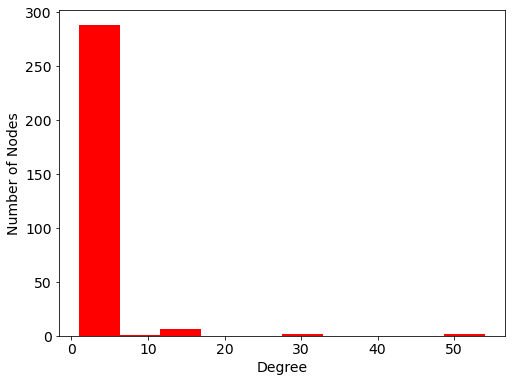

In [95]:
drawHist(hashNetwork, "red", degree_seq_hash, "Number of Nodes", "Degree")

Illustrating the degree analysis. As we can see, there are many nodes which have few degrees, but few nodes with higher degrees

In [96]:
#identifying the hashtags with the highest degree
degrees = dict( hashNetwork.degree(hashNodes, weight = "weight") )
s_deg = pd.Series( degrees )
df_summary = pd.DataFrame( {"weight" : s_deg} )
df_summary.sort_values( by="weight", ascending=False ).head(10)

,weight
SmartInvesting,58
COVID19,55
NasdaqListed,55
WSJWhatsNow,47
AskReuters,36
Bitcoin,23
sponsored,19
GreenVoices,18
ESG,17
TheYearAhead,17


The hashtag SmartInvesting, COVID19 and NasdaqListed have the highest weights in the network

In [97]:
#identifying the user with the highest degree
user_deg = dict(hashNetwork.degree(userNodes, weight="weight") )
s_deg = pd.Series( user_deg )
df_summary = pd.DataFrame( {"weight" : s_deg} )
df_summary.sort_values( by="weight", ascending=False ).head(10)

,weight
Nasdaq,331
Reuters Money,116
NBC News Business,59
BBC Business,50
The Wall Street Journal,49
Bloomberg Markets,49
BBC World Business,36
Telegraph Business,33
Entrepreneur,29
Independent Business,24


Nasdaq has the highest amount of hashtags that it tweets out

In [98]:
#creating a projected network
g = bipartite.weighted_projected_graph(hashNetwork, hashNodes)
print ("Created projected network %d nodes, %d edges" % ( len(g), g.number_of_edges() ))

Created projected network 274 nodes, 4191 edges


In [99]:
# get all the edge weights
weights = {}
for e in g.edges(data=True):
    pair = (e[0],e[1])
    weights[pair] = e[2]["weight"]
s_weights = pd.Series( weights ) 
df_weights = pd.DataFrame( {"weight" : s_weights} )
# display the most frequent overlaps (i.e. top weights)
df_weights.sort_values(by="weight",ascending=False).head(10)

,,weight
crypto,TheYearAhead,3
SmallBusiness,SmallBiz,2
5Things,Bitcoin,2
coronavirus,business,2
Bitcoin,TheYearAhead,2
COVID19,coronavirus,2
ceosecrets,WorldBusinessReport,2
bitcoin,ReutersLive,2
CyberMonday,BlackFriday,2
COVID19,economy,2


The table above gives us the most common overlaps in this dataset. This makes sense since crypto is associated with "the year ahead" which could be projections, while "COVID19" is associated with "business" as many businesses suffered due to COVID19

In [100]:
between = pd.Series(dict( nx.betweenness_centrality(g) ), name="betweenness")
pd.DataFrame(between).sort_values(by="betweenness", ascending=False).head(10)

,betweenness
COVID19,0.117413
jobs,0.100378
coronavirus,0.093583
InaugurationDay,0.085156
CovidVaccine,0.083710
Bitcoin,0.057291
Election2020,0.056874
stockmarket,0.044095
ceosecrets,0.041667
WorldBusinessReport,0.041667


As we can see, COVID19 has the highest betweenness in this network. This makes sense since a lot of different areas have been affected by it.

## Task 5 - Hashtag Co-Occurrence Network
- Here each node will correspond to a hashtag appearing in one or more of the tweets of list users.

In [101]:
#creating a list of hashtags from the dataframe
usernames = []
for i, row in userHashtag.iterrows():
        usernames.append(row['name'])

In [102]:
#creating pairs by appending the name of the account and the text of the hashtag
pairs = []
for i, row in userHashtag.iterrows():
    for j in range(len(row['hashtags'])):
            pairs.append((row['name'], row['hashtags'][j]['text']))

In [103]:
#regrouping the hashtags
hashtagStore = {}
for u in usernames:
    hashtagStore[u] = []
for p in pairs:
    if (p[0] != p[1]):
        hashtagStore[p[0]].append( p[1] )

In [104]:
pair_counts = Counter()
for h in hashtagStore:
    # use itertools to find all unique combinations
    hPairs = list( itertools.combinations(hashtagStore[h], r=2) )
    # update the pair counts
    for pair in hPairs:
        #making sure the same hashtags are not paired together 
        if (pair[0] != pair[1]):
            pair_counts[pair] += 1

In [105]:
#adding the nodes and edges in the network
coNet = nx.Graph()
for pair in pair_counts:
    coNet.add_edge( pair[0], pair[1], weight=pair_counts[pair] )

In [106]:
# get all the edge weights
weights = {}
for e in coNet.edges(data=True):
    pair = (e[0],e[1])
    weights[pair] = e[2]["weight"]
s_weights = pd.Series( weights ) 
df_weights = pd.DataFrame( {"weight" : s_weights} )
# display the most frequent overlaps (i.e. top weights)
df_weights.sort_values(by="weight",ascending=False).head(10)

weight
NasdaqListed   SmartInvesting    1623
COVID19        SmartInvesting    1286
               NasdaqListed      1196
NasdaqListed   GreenVoices        546
GreenVoices    SmartInvesting     477
COVID19        GreenVoices        448
SmartInvesting ESG                445
NasdaqListed   ESG                439
               TradeTalks         422
TradeTalks     SmartInvesting     357

A network has been created as can be seen in the table above. We can see which hashtags are associated with which other hashtag the most in this network. Given the large size of the network, I will plot it as an ego network in the characterisation. 

**Hashtag Co-Occurence Characterisation**

In [107]:
deg = nx.degree_centrality(coNet)
s = pd.Series(deg)
df = pd.DataFrame(s,columns=["degree_centrality"])
# display the DataFrame sorted by degree centrality
df.sort_values(by="degree_centrality",ascending=False).head(10)

bet = nx.betweenness_centrality(coNet)
df["betweenness"] = pd.Series(bet)
df.sort_values(by="betweenness",ascending=False).head(10)

close = nx.closeness_centrality(coNet)
df["closeness"] = pd.Series(close)
df.sort_values(by="closeness",ascending=False).head(10)

,degree_centrality,betweenness,closeness
COVID19,0.466912,0.118280,0.562540
coronavirus,0.363971,0.094273,0.521030
stockmarket,0.371324,0.044420,0.506843
InaugurationDay,0.341912,0.085785,0.505592
jobs,0.261029,0.101119,0.503107
Election2020,0.297794,0.057294,0.498211
economy,0.290441,0.017657,0.494601
business,0.290441,0.017657,0.494601
ICYMI,0.279412,0.034712,0.481799
Bitcoin,0.272059,0.057713,0.476197


As we can see from the centrality measures, we can see that the coronavirus, stocks and the election was at the top of the list. This makes sense since these are quite topical and relevant hashtags. The COVID19 hashtag is at the top with a high centrality, betweenness and closeness degree, meaning it had the most influence. This makes sense since a lot of factors in the world were affected by it so it is bound to appear alongside other tweets. It is interesting how we can derive the influence something had on the world through the means of hashtags on social media

In [108]:
graphsData = {'Nodes': [coNet.number_of_nodes()], 'Edges': [coNet.number_of_edges()], 
              'Density': [nx.density(coNet)], 'Number of Connected Components': [nx.number_connected_components(coNet)]}
graphsData = pd.DataFrame(graphsData, columns = ['Nodes', 'Edges', 'Density', 'Number of Connected Components'], 
                  index=['Hashtag Network'])
graphsData

,Nodes,Edges,Density,Number of Connected Components
Hashtag Network,273,4191,0.11288,7


There are 273 nodes that have 4191 edges, so this is quite a large network. The density is just over 0.11 and there are 7 connected components in total. In order to get a better idea of how a co-occurence network looks, I made an ego network:

In [109]:
#creating an ego network
ego_node = "crypto"
eg = nx.ego_graph(coNet, ego_node)

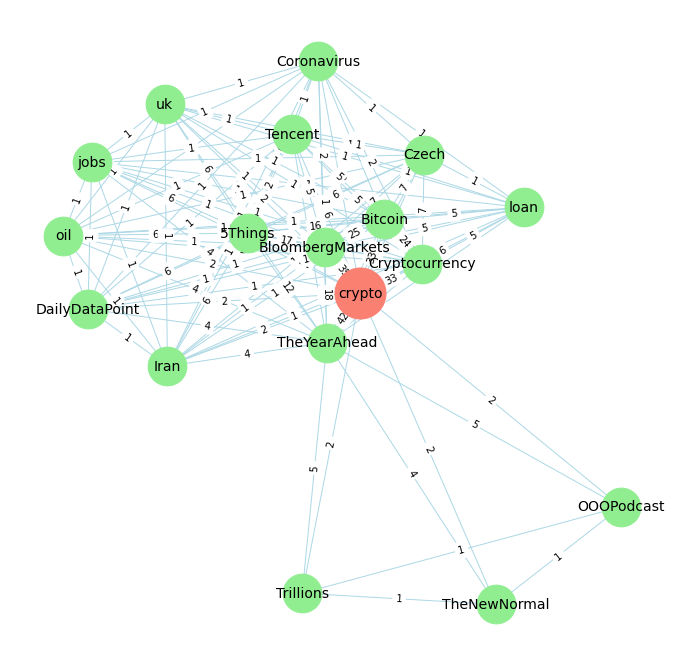

In [110]:
plt.figure(figsize=(12, 12)) 
plt.margins(0.1, 0.1)
# apply layout algorithm to calculate node positions
pos = nx.spring_layout( eg )
# draw the nodes and edges
nx.draw(eg, pos, with_labels = True, node_size=1500, font_size=14, node_color="lightgreen", edge_color="lightblue")
# draw the ego in red, with larger node size
nx.draw_networkx_nodes(eg, pos, nodelist=[ego_node], node_size=2600, node_color="#FA8072")
# now add the edge weights as labels
labels = nx.get_edge_attributes(eg, 'weight')
nx.draw_networkx_edge_labels(eg, pos,edge_labels=labels);

Made an ego network with "crypto" as the ego node. This plot shows us all the hashtags that are associated with the "crypto" hashtag. As we can see, a lot of these nodes make sense since a lot are finance related. There are however some other nodes like "Iran" and "Czech" which are interesting to see in the network too

In [111]:
graphsData = {'Nodes': [eg.number_of_nodes()], 'Edges': [eg.number_of_edges()], 
              'Density': [nx.density(eg)], 'Number of Connected Components': [nx.number_connected_components(eg)]}
graphsData = pd.DataFrame(graphsData, columns = ['Nodes', 'Edges', 'Density', 'Number of Connected Components'], 
                  index=['Hashtag Network'])
graphsData

,Nodes,Edges,Density,Number of Connected Components
Hashtag Network,18,114,0.745098,1


As we can see, this one connected component has a much higher density than the previous graph which makes sense because it is all connected more closely

In [112]:
list(eg.neighbors("TheNewNormal"))

['TheYearAhead', 'OOOPodcast', 'Trillions', 'crypto']

Seeing the neighbours of a given node int the ego network

In [113]:
co_degree = dict( eg.degree())

In [114]:
degree_seq_hash = pd.Series(co_degree)

In [115]:
degree_range = (degree_seq_hash.min(), degree_seq_hash.max())

In [116]:
degree_mean = degree_seq_hash.mean()

In [117]:
degree_median = degree_seq_hash.median()

In [118]:
#representing the data in the form of a dataframe for ease of viewing
DegreeData = {'Degree Range': [degree_range], 'Degree Mean': [degree_mean], 
              'Degree Median': [degree_median]}
DegreeData = pd.DataFrame(DegreeData, columns = ['Degree Range', 'Degree Mean', 'Degree Median'], 
                  index=['Co Occurence Network'])
DegreeData

,Degree Range,Degree Mean,Degree Median
Co Occurence Network,"(4, 17)",12.666667,14.0


This network has a mean degree of 12, and a range between 4 and 17. This shows us that it is a well connected graph

In [119]:
#identifying the hashtags with the highest weight
degrees = dict( eg.degree(co_degree, weight = "degree") )
s_deg = pd.Series( degrees )
df_summary = pd.DataFrame( {"degree" : s_deg} )
df_summary.sort_values( by="degree", ascending=False ).head(10)

,degree
crypto,17
TheYearAhead,17
jobs,14
loan,14
DailyDataPoint,14
Tencent,14
Bitcoin,14
Iran,14
Cryptocurrency,14
Coronavirus,14


As we can see, the hashtags "TheYearAhead" and "Crypto" have the highest degrees in this network

In [120]:
# get all the edge weights
weights = {}
for e in eg.edges(data=True):
    pair = (e[0],e[1])
    weights[pair] = e[2]["weight"]
s_weights = pd.Series( weights ) 
df_weights = pd.DataFrame( {"weight" : s_weights} )
# display the most frequent overlaps (i.e. top weights)
df_weights.sort_values(by="weight",ascending=False).head(10)

weight
TheYearAhead     crypto              42
BloombergMarkets crypto              35
Bitcoin          crypto              33
Cryptocurrency   crypto              33
BloombergMarkets Bitcoin             25
                 Cryptocurrency      25
Cryptocurrency   Bitcoin             24
5Things          crypto              21
BloombergMarkets TheYearAhead        18
TheYearAhead     Bitcoin             18

We are able to see the hashtags that appear next to each other the most often. This is for the ego network which makes sense as it is all mainly finance related

## Conclusion

As we saw, I created 5 networks in this assignment. A Follower Network, a Reply Network, a Mention Network, a User-Hashtag network and a Hashtag Co-occurence Network.

For each network I constructed and characterised it using the pre collected Twitter Data